# Deutsch Algorithm
This notebook will go over the basics of Deutsch Algorithm and how to implement it on Qiskit.

## Deutsch Problem
Suppose a function $f: \{0,1\} \to \{0,1\}$
If the output is same for different inputs, it is a constant function.
If the output is different it is a balanced function.

Classically, in order to evalute the function, two calls of the function is needed.
But with a Quantum Machine, we could evaluate the function with one iteration of the algorithm.

Deutsch Algorithm is a special case of Deutsch-Jozsa Algorithm when n=1.

### Let's start with building the function
We want a function that can do the following:

| $x$ | $f_1(x)$ | $f_2(x)$ | $f_3(x)$ | $f_4(x)$ |
|-----|----------|----------|----------|----------|
| 0   | 0        | 0        | 1        | 1        |
| 1   | 0        | 1        | 0        | 1        |


In [67]:
from qiskit import QuantumCircuit

def target_function(case: int):
    if case not in [1, 2, 3, 4]:
        raise ValueError("'case' must be 1, 2, 3, or 4.")
    
    f = QuantumCircuit(2)
    if case in [2,3]:
        f.cx(0,1)
    if case in [3,4]:
        f.x(1)
    return f

### Now start building our Deutsch Algorithm

Initialize the qubits to $\lvert - \rangle \lvert + \rangle$ state,
which can be expressed as $\frac{1}{2}(\lvert 0 \rangle - \lvert 1 \rangle)\lvert 0 \rangle + \frac{1}{2}(\lvert 0 \rangle - \lvert 1 \rangle)\lvert 1 \rangle$.

Here, I am following Qiskit's qubit ordering convention, which puts the top qubit to the right and the bottom qubit to the left.

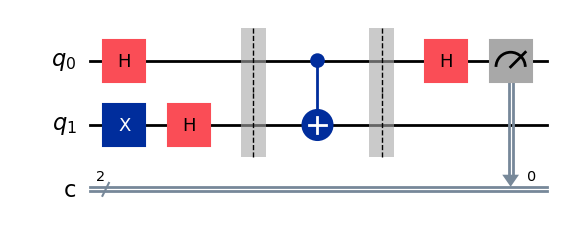

In [68]:
qc = QuantumCircuit(2,2) # 2 qubit system, 2 classical bits to store measurement

qc.h(0)
qc.x(1)
qc.h(1)
qc.barrier()
qc.compose(target_function(2), inplace=True)
qc.barrier()
qc.h(0)
qc.measure(0,0)

qc.draw("mpl")

Here, I am skipping some math. But we will acquire 0 for $q_0$ from a constant function and 1 for $q_1$ from a balanced function.

The final state can be written as:

$$
\begin{cases}
(-1)^{f(0)} \lvert - \rangle \lvert 0 \rangle, & \text{if } f(0) \oplus f(1) = 0, \\
(-1)^{f(0)} \lvert - \rangle \lvert 1 \rangle, & \text{if } f(0) \oplus f(1) = 1.
\end{cases}
$$

where $\oplus$ denotes addition modulo 2 (or binary dot product )

## Loading Real Backend
This codes sets up backend service from the least busy QPU. <br>
(Make sure you have an IBM account)

In [69]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

service = QiskitRuntimeService()
backend = service.least_busy(simulator=False, operational=True) # Check what the parameters mean
print("Using backend: ",backend.name)

management.get:WARNING:2025-12-27 00:59:11,042: Loading default saved account


Using backend:  ibm_torino


## Loading Backend Sampler
A simulator would also work well for this algorithm.

In [70]:
from qiskit.primitives import BackendSamplerV2
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel 

noise_model = NoiseModel.from_backend(backend)

# Defining a backend simulator with Aer
backend_sim = AerSimulator(noise_model=noise_model)
sampler_sim = BackendSamplerV2(backend=backend_sim)

## Transpiling the Circuit
Optimizing the ciruit for real hardware topology.

In [71]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target # QPU we are targeting
pm = generate_preset_pass_manager(target=target, optimization_level=3)

qc_isa = pm.run(qc)

## Execute

In [ ]:
# job = sampler.run([qc_isa], shots=1) # Uncomment to run on real QPU
job = sampler_sim.run([qc_isa], shots=50)

result = job.result()
counts = result[0].data.c.get_counts()

## Visualize Results

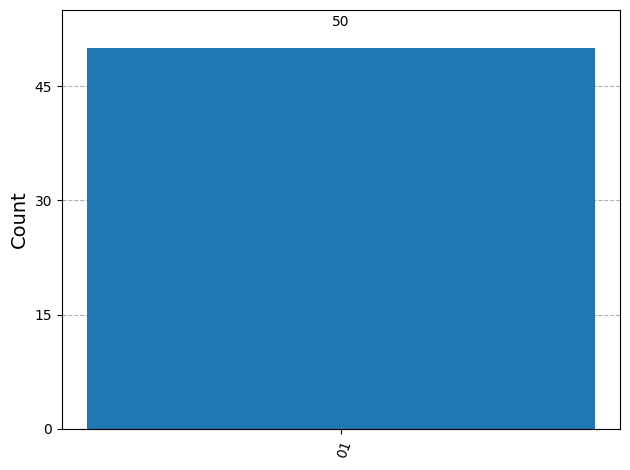

In [ ]:
from qiskit.visualization import plot_histogram

plot_histogram(counts)

The function we use for this demonstration is function 2, which the result (1 on the right qubit) agrees with our calculations.